Packages

In [43]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()
from statsmodels.tsa.api import VAR

Loading data

In [2]:
raw_data = yfinance.download (tickers = "^GSPC ^FTSE ^N225 ^GDAXI", start = "2000-01-03", 
                              end = "2020-03-02", interval = "1d", group_by = 'ticker', auto_adjust = True, treads = True)

[*********************100%***********************]  4 of 4 downloaded


In [3]:
df_com = raw_data.copy()

In [4]:
df_com['spx'] = df_com['^GSPC'].Close[:]
df_com['dax'] = df_com['^GDAXI'].Close[:]
df_com['ftse'] = df_com['^FTSE'].Close[:]
df_com['nikkei'] = df_com['^N225'].Close[:]

In [5]:
df_com = df_com.iloc[1:]
del df_com['^N225']
del df_com['^GSPC']
del df_com['^GDAXI']
del df_com['^FTSE']
df_com=df_com.asfreq('b')
df_com=df_com.fillna(method='ffill')

In [6]:
df_com['ret_spx'] = df_com.spx.pct_change(1).mul(100)
df_com['ret_ftse'] = df_com.ftse.pct_change(1).mul(100)
df_com['ret_dax'] = df_com.dax.pct_change(1).mul(100)
df_com['ret_nikkei'] = df_com.nikkei.pct_change(1).mul(100)

In [7]:
df_com['norm_ret_spx'] = df_com.ret_spx.div(df_com.ret_spx[1])*100
df_com['norm_ret_ftse'] = df_com.ret_ftse.div(df_com.ret_ftse[1])*100
df_com['norm_ret_dax'] = df_com.ret_dax.div(df_com.ret_dax[1])*100
df_com['norm_ret_nikkei'] = df_com.ret_nikkei.div(df_com.ret_nikkei[1])*100

In [8]:
size = int(len(df_com)*0.8)
df, df_test = df_com.iloc[:size], df_com.iloc[size:]

In [9]:
model_ar = ARIMA(df.spx, order = (1,0,0))
results_ar = model_ar.fit()

In [14]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2016-02-17"

In [21]:
end_date = "2020-01-02"
df_pred = results_ar.predict(start = start_date, end = end_date)

ARMAX

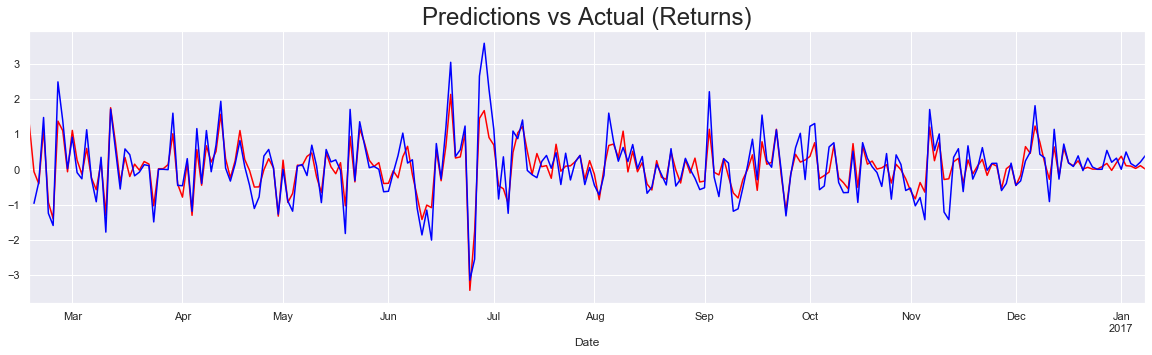

In [34]:
model_ret_armax = ARIMA(df.ret_spx[1:], exog = df[["ret_ftse","ret_dax","ret_nikkei"]][1:], order = (1,0,1))
results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(start = start_date, end = end_date, 
                                          exog = df_test[["ret_ftse","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

SARIMAX

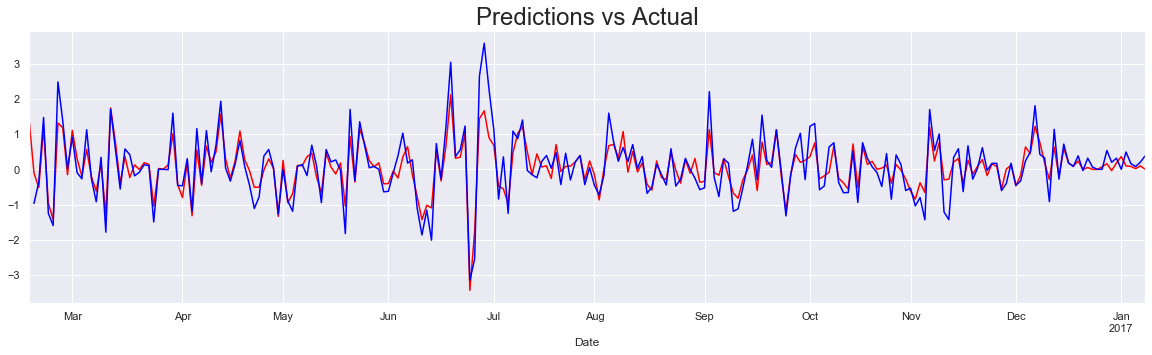

In [36]:
end_date = "2017-01-09"
model_ret_sarimax = SARIMAX(df.ret_spx[1:], exog = df[["ret_ftse","ret_dax","ret_nikkei"]][1:], 
                            order = (3,0,4), seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(start = start_date, end = end_date, 
                                              exog = df_test[["ret_ftse","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

Auto ARIMA

In [37]:
model_auto = auto_arima(df.ret_spx[1:], exogenous = df[['ret_ftse', 'ret_dax', 'ret_nikkei']][1:],
                       m = 5, max_p = 5, max_q = 5, max_P = 5, max_Q = 5)

In [38]:
df_auto_pred = pd.DataFrame(model_auto.predict(n_periods = len(df_test[start_date:end_date]),
                            exogenous = df_test[['ret_ftse', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
                            index = df_test[start_date:end_date].index)

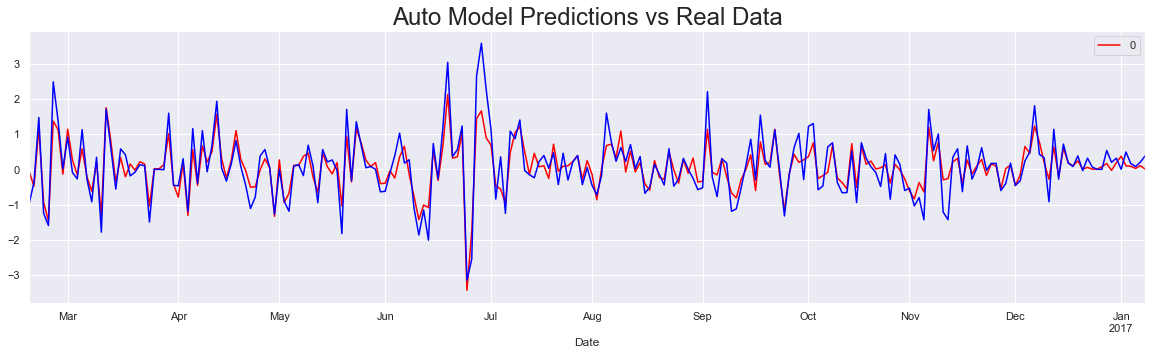

In [39]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

Comparing All the Models

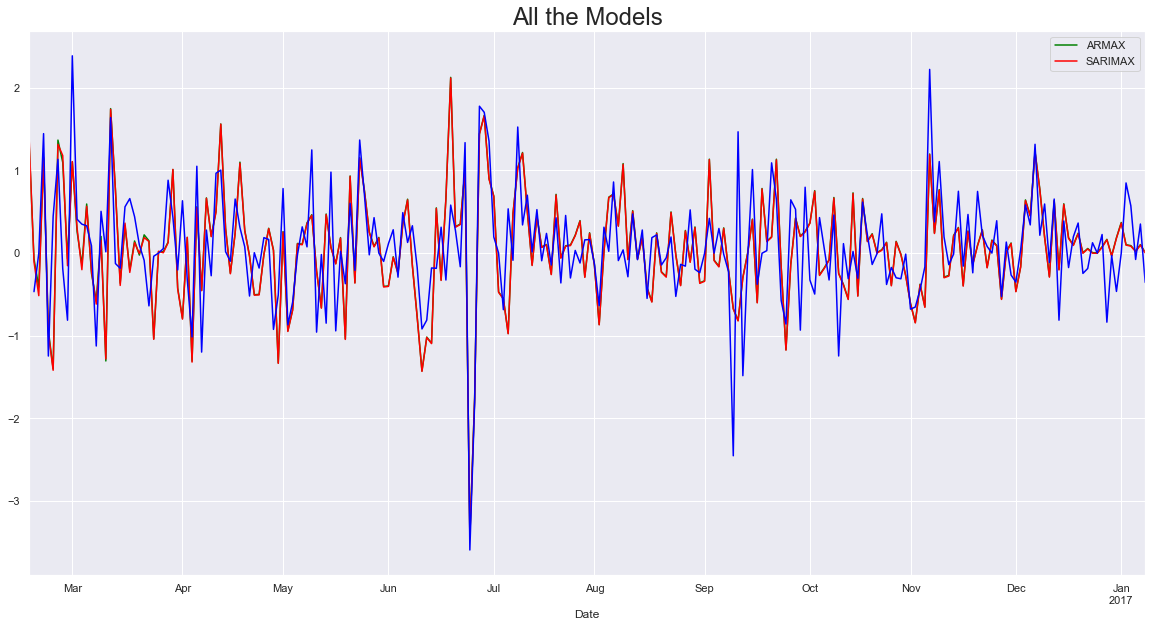

In [99]:
end_date = "2017-01-09"
df_pred_armax[start_date:end_date].plot(figsize = (20,10), color = "green")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_spx[start_date:end_date].plot(figsize = (20,10), color = "blue")
plt.legend(['ARMAX','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()
#SARIMAX is the best, 2nd is the ARMAX

Forecasting Volatility

In [47]:
mod_garch = arch_model(df_com.ret_spx[1:], vol = "GARCH", p = 1, q = 1, mean = "constant", dist = "Normal")
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     71,   Neg. LLF: 5933.479683347461
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5933.479089160644
            Iterations: 12
            Function evaluations: 84
            Gradient evaluations: 12


In [102]:
pred_garch = res_garch.forecast(horizon = 1, align = 'target')
#horizon=how many obsevations we want our model to predict for each date
#for each date,we'll get the predicted value, for the next date
#align=determines whether we match the value with the date is made on, or the one it's supposed to represent

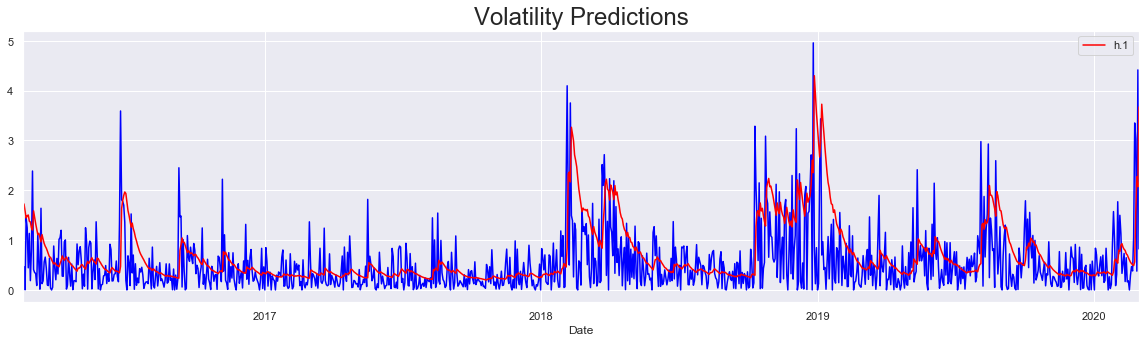

In [103]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_spx.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [104]:
pred_garch = res_garch.forecast(horizon = 1000, align = 'target')
pred_garch.residual_variance[-1:]#last day of our dataset

,h.0001,h.0002,h.0003,h.0004,h.0005,h.0006,h.0007,h.0008,h.0009,h.0010,...,h.0991,h.0992,h.0993,h.0994,h.0995,h.0996,h.0997,h.0998,h.0999,h.1000
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-28,3.671918,2.064231,2.249981,1.555333,0.600294,0.538137,0.565327,0.594652,0.63121,0.680337,...,1.364592,1.364593,1.364592,1.364592,1.364592,1.364592,1.364593,1.364593,1.364593,1.364592
